# Iot HouseHold Consumption

[Data Source (UCI ML Repository)](http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import seaborn as sns

In [4]:
# Code was initially used to extract a subset of dataset that originally contained over 2 million observations
# no need to run again

'''
# 129600 rows is equivalent to 3 months worth of data
# 20160
power = pd.read_csv('Data/household_power_consumption.csv', sep= ';', nrows=129600, parse_dates=[['Date', 'Time']],
                   names = ['Date', 'Time','Global_active_power', 'Global_reactive_power', 'Voltage',
                                'Global_intensity', 'Kitchen', 'Laundry',
                                'Heat_AC'],
                   skiprows=1)

power = power.set_index('Date_Time')

power.to_csv('Data/household_power_consumption.csv')'''

In [10]:
power = pd.read_csv('Data/household_power_consumption.csv', parse_dates=['Date_Time'])
power = power.set_index('Date_Time')
power.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen,Laundry,Heat_AC
Date_Time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [11]:
power.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Kitchen', 'Laundry', 'Heat_AC'],
      dtype='object')

In [12]:
len(power)

129600

In [13]:
power.dtypes

Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Kitchen                   object
Laundry                   object
Heat_AC                  float64
dtype: object

In [143]:
power = power[pd.to_numeric(power['Global_active_power'], errors='coerce').notnull()]
power = power[pd.to_numeric(power['Global_reactive_power'], errors='coerce').notnull()]
power = power[pd.to_numeric(power['Voltage'], errors='coerce').notnull()]
power = power[pd.to_numeric(power['Global_intensity'], errors='coerce').notnull()]
power = power[pd.to_numeric(power['Kitchen'], errors='coerce').notnull()]
power = power[pd.to_numeric(power['Laundry'], errors='coerce').notnull()]
power = power[pd.to_numeric(power['Heat_AC'], errors='coerce').notnull()]

In [15]:
len(power)

129592

In [16]:
power.dtypes

Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Kitchen                   object
Laundry                   object
Heat_AC                  float64
dtype: object

In [17]:
# changing dtypes from object to numeric
for i in list(power.columns):
    power[[i]] = power[[i]].apply(pd.to_numeric)

In [18]:
power.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Kitchen                  float64
Laundry                  float64
Heat_AC                  float64
dtype: object

## Python Data Science Handbook

Jake Vanderplas has a [chapter dedicated to dealing with time series data](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html) in his book, *Python Data Science Handbook*. It's been a huge help!

In [20]:
# Note that '2007-03-16' is the last date it seems?

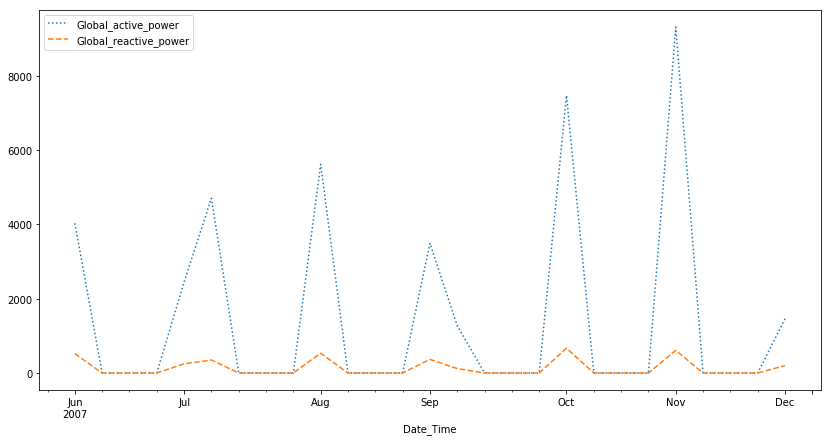

In [21]:
# Daily global reactive power
# It appears that the Global power spikes at the end/beginning of every month

weekly = power.loc['2007-06-01':'2007-12-01', ['Global_active_power', 'Global_reactive_power']].resample('W').sum()
weekly.plot(style=[':', '--', '-'], figsize=(14, 7))

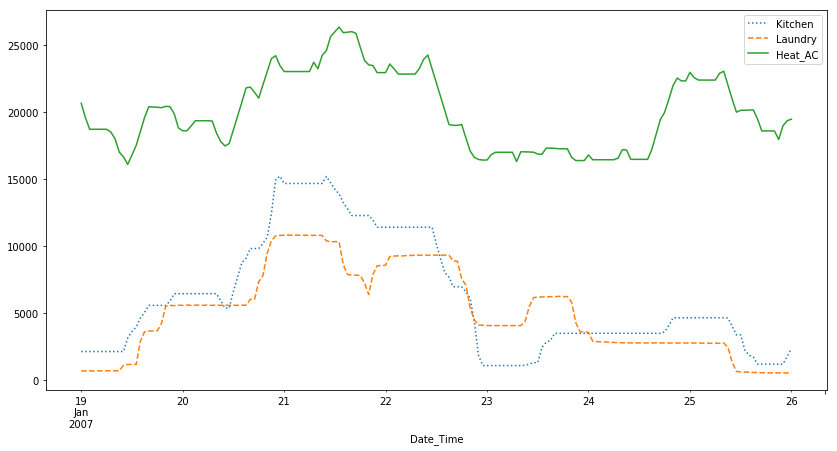

In [25]:
hourly_rolling_winter = power.loc['2007-01-18':'2007-01-26', ['Kitchen', 'Laundry', 'Heat_AC']].resample('H').sum()
hourly_rolling_winter.rolling(48, center=True).sum().plot(style=[':', '--', '-'], figsize=(14, 7))

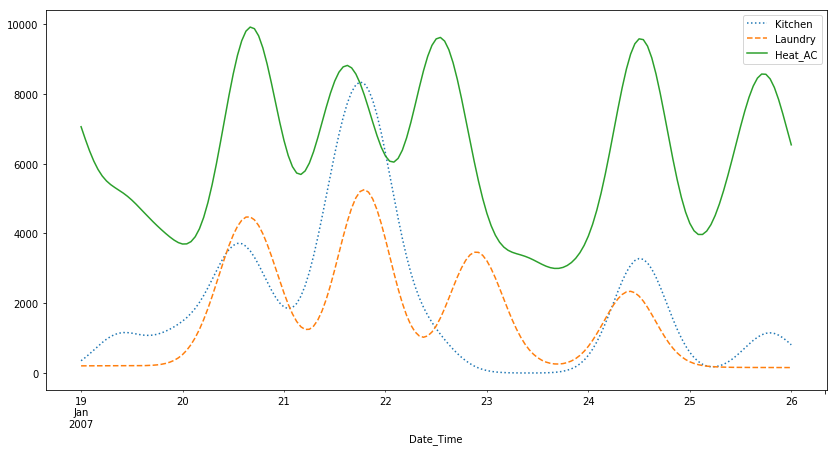

In [26]:
# rolling mean window function with window width of 48 hours and width of Gaussian = 6 hours
hourly_rolling_winter.rolling(48, center=True,
              win_type='gaussian').sum(std=6).plot(style=[':', '--', '-'], figsize=(14, 7));

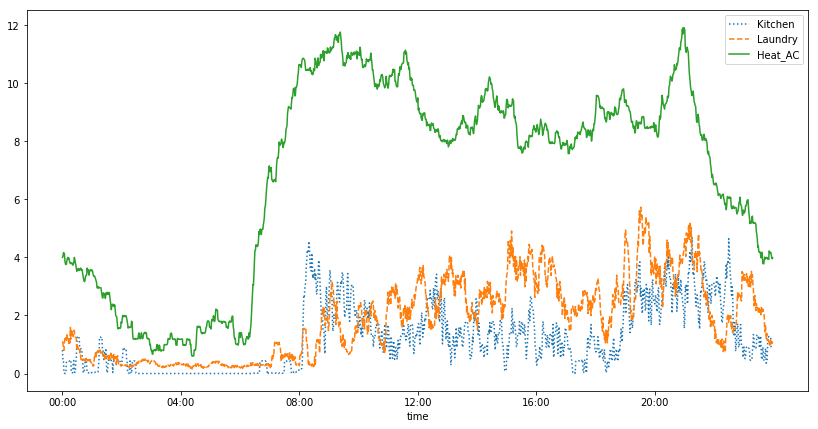

In [27]:
# Data Aggregation, Distribution of each sub_meter by hour!
by_time = power[['Kitchen', 'Laundry', 'Heat_AC']].groupby(power.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-'], figsize=(14, 7));

### Let's look specifically at the kitchen

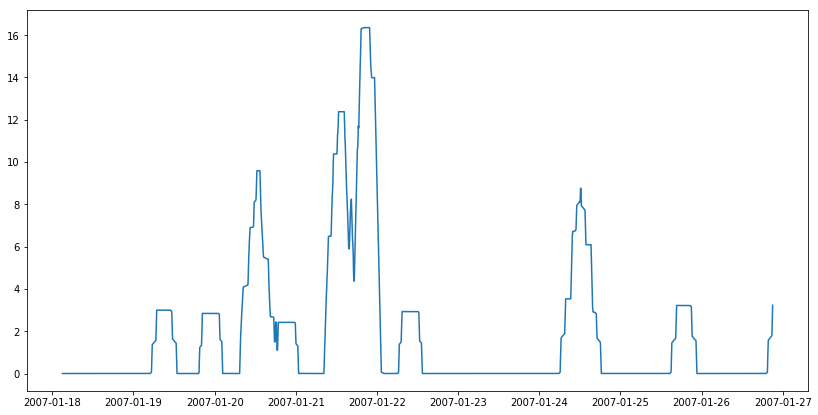

In [30]:
# Kitchen output over the course of a week, rolling averaged over the past 6 hours
plt.figure(figsize=(14, 7))
kitchen = power.loc['2007-01-18':'2007-01-26', ['Kitchen']]
plt.plot(kitchen.rolling(360, center=True).mean())

### Let's look at the Heat_AC

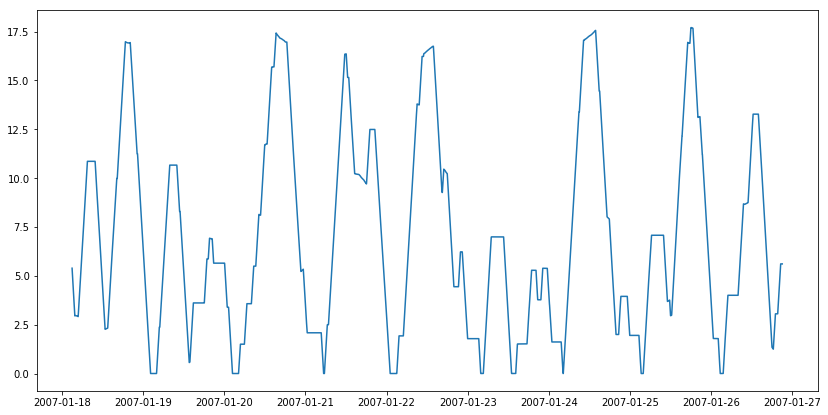

In [34]:
plt.figure(figsize=(14, 7))
Heat_AC = power.loc['2007-01-18':'2007-01-26', ['Heat_AC']]
#Heat_AC.rolling(360, center=True).mean()
plt.plot(Heat_AC.rolling(360, center=True).mean())

---

---

It appears that `Global_active_power`, `Global_reactive_power`, and `Global_intensity` take on an exponential distribution. `Voltage` has a relatively normal distribution.

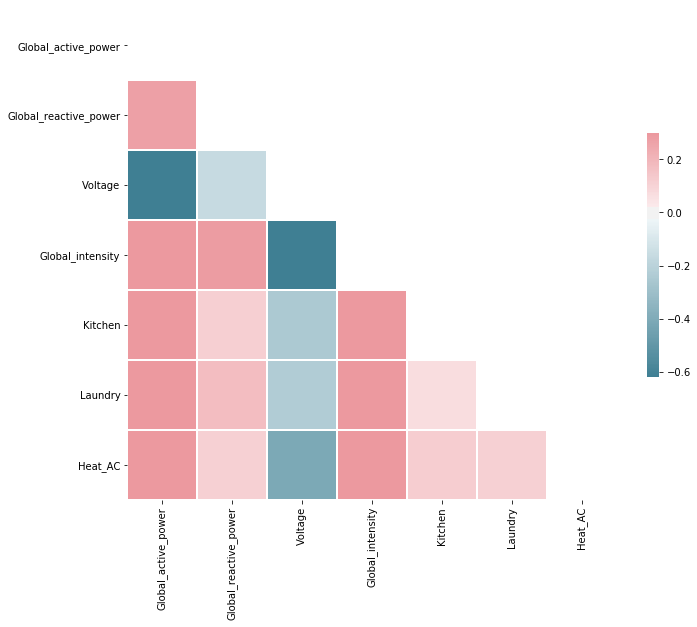

In [77]:
# Compute the correlation matrix
corr = power.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})